### Training

In [65]:
import utils.sound_utils as su
import utils.train_utils as tu
import utils.filter_utils as filter
import wget

import os
import sys
import importlib
import pickle
import numpy as np
import pandas as pd

importlib.reload(su)
importlib.reload(tu)
importlib.reload(filter)


<module 'utils.filter_utils' from 'c:\\Users\\gonza\\OneDrive\\Documentos\\Gonzalo\\Especializacion\\inteligencia_embebida\\esp32_loopback\\python\\utils\\filter_utils.py'>

In [4]:

#wget.download('https://www.dropbox.com/s/d12x5vknrk9yek1/data.zip')
#wget.download('https://www.dropbox.com/s/qoyduoa5prupyzr/test_files.csv')
#wget.download('https://www.dropbox.com/s/z1cwznln0gfpw32/train_labels.csv')

'train_labels.csv'

In [58]:
labels = {
    0: "bite",
    1: "chew",
    2: "chew_byte"
}

In [59]:
train = pd.read_csv("data/train_labels.csv")
test = pd.read_csv("data/test_files.csv")

In [60]:
train.head()

,filename,pasture,height,label
0,4,alfalfa,tall,2
1,9,alfalfa,tall,2
2,10,alfalfa,tall,1
3,11,alfalfa,tall,2
4,13,alfalfa,tall,2


In [61]:
test.head()

,filename
0,1
1,2
2,3
3,5
4,6


In [66]:
dataset = tu.upload_dataset("data/audios")

In [27]:
sample_rate = 22050
f_cutoff = 5
f_norm = f_cutoff / sample_rate
window_size = (0.196202 + f_norm ** 2) ** 0.5 / f_norm

filter_ma = filter.MovingAverage(window_size=int(window_size))
filtered_data = []


for _, audio in dataset:
    filtered_aux = []
    for value in audio:
        absolute = abs(value) if abs(value) >= 0 else np.iinfo(value.dtype).max
        filtered_aux.append(filter_ma.calculate_ma(absolute))
    filtered_data.append(filtered_aux)
    
    

In [33]:
with open('data/filtered_data.pkl', 'wb') as f:
    pickle.dump(filtered_data, f)

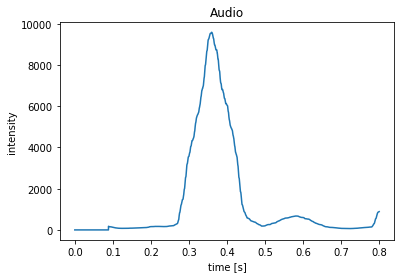

In [34]:
from utils.sound_utils import plot_audio

plot_audio(filtered_data[0], sample_rate)

In [40]:
noise_gate_data = []
noise_gate = su.NoiseGate(open_threshold=1500, close_threshold=1000, hold=0)
for data in filtered_data:
    filtered_data_list, init, end = noise_gate.split(data, sample_rate)
    if len(filtered_data_list) == 1:
        noise_gate_data.append(filtered_data_list[0])
    elif len(filtered_data_list) > 0:
        noise_gate_data.append(filtered_data_list[0])
    else:
        noise_gate_data.append([])

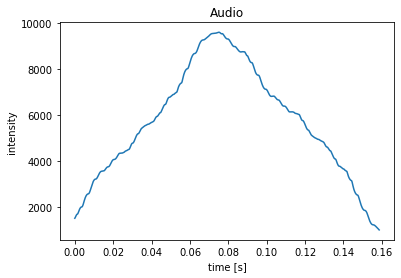

In [42]:
plot_audio(noise_gate_data[0], sample_rate)

In [50]:
extracted_data = []
for data in noise_gate_data:
    extractor = su.FeatureExtractor(data, sample_rate)
    extracted_data.append(extractor.extract_features())

In [51]:
with open('data/extracted_data.pkl', 'wb') as f:
    pickle.dump(extracted_data, f)

In [52]:
extracted_data[0]

[0.15863945578231292,
 9584.596006144386,
 63,
 0.47566218969130075,
 2383.2023133242296]

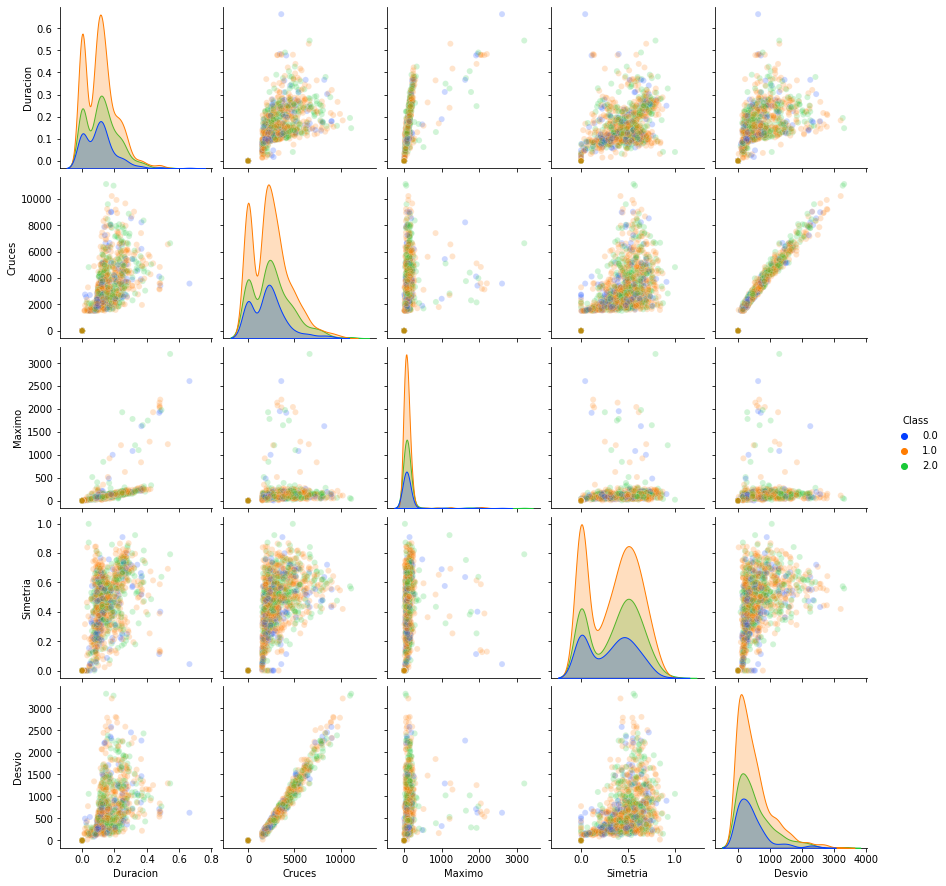

In [53]:
import pandas.testing as tm
import seaborn

colnames = ["Duracion", "Cruces", "Maximo", "Simetria", "Desvio"]

df_train = pd.DataFrame(extracted_data, columns=colnames)
df_train.insert(len(df_train.columns), "Class", train["label"])

seaborn.pairplot(df_train,
                 vars=colnames,
                 hue="Class",
                 plot_kws={'alpha':0.2},
                 palette="bright")